In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Lambda

In [2]:
data_path = "/kaggle/input/scaled/btc_scaled_features.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
btc_full = pd.read_csv("/kaggle/input/full-sentiment/btc_full_with_sentiment.csv", index_col=0, parse_dates=True)
print("Final shape:", btc_full.shape)
print("Final shape:", df.shape)

Final shape: (3759, 22)
Final shape: (3759, 22)


In [3]:
target_col = 'close'

feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'sma_7', 'sma_21', 'ema_7', 'ema_21',
    'rsi_14', 'daily_return', 'high_low_spread', 'close_open_diff',
    'dayofweek', 'month', 'is_weekend',
    'tweet_vader_sentiment', 'news_sentiment', 'fear_greed_index',
    'tweet_sentiment_available', 'news_sentiment_available', 'fear_greed_available'
]

In [4]:
def create_sequences(data, target_col_idx, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i][target_col_idx])
    return np.array(X), np.array(y)

sequence_length = 60

scaled = df[feature_cols]
X, y = create_sequences(scaled.values, feature_cols.index(target_col), sequence_length)

In [5]:
def split_data(X, y, train_ratio=0.7, val_ratio=0.1):
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]

    y_train = y[:train_size]
    y_val = y[train_size:train_size + val_size]
    y_test = y[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [6]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label='Model'):
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=100,
        callbacks=[callback],
        verbose=2
    )

    preds = model.predict(X_test).flatten()

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    corr, _ = pearsonr(y_test, preds)

    print(f"🔹 {label} Results:")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} | Pearson Corr: {corr:.4f}")

    return preds, mae, rmse, r2, corr

In [7]:
def plot_and_evaluate_usd(y_test_scaled, y_pred_scaled, btc_full_df, feature_cols, scaler, model_name='Model'):
    btc_model = btc_full_df[feature_cols].copy()
    scaler.fit(btc_model)

    y_test_full = np.zeros((len(y_test_scaled), len(feature_cols)))
    y_test_full[:, feature_cols.index("close")] = y_test_scaled.flatten()

    y_pred_full = np.zeros((len(y_pred_scaled), len(feature_cols)))
    y_pred_full[:, feature_cols.index("close")] = y_pred_scaled.flatten()

    y_test_real = scaler.inverse_transform(y_test_full)[:, feature_cols.index("close")]
    y_pred_real = scaler.inverse_transform(y_pred_full)[:, feature_cols.index("close")]

    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Actual Price (USD)')
    plt.plot(y_pred_real, label='Predicted Price (USD)')
    plt.title(f"{model_name} - BTC Price Prediction vs Actual (USD)")
    plt.xlabel("Time Step")
    plt.ylabel("BTC Price ($)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/kaggle/working/{model_name}_plot.png')
    plt.show()

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2 = r2_score(y_test_real, y_pred_real)
    corr, _ = pearsonr(y_test_real, y_pred_real)

    print(f"📈 {model_name} Evaluation in USD:")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson Correlation: {corr:.4f}")


In [8]:
def build_residual_gru_light_dropout(input_shape):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = Dropout(0.05)(x)
    x = GRU(64)(x)
    x = Dropout(0.05)(x)
    x = Dense(1)(x)
    shortcut = Lambda(lambda z: z[:, -1, 0:1])(inp)
    out = Add()([x, shortcut])
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model


model_gru = build_residual_gru_light_dropout((X_train.shape[1], X_train.shape[2]))

preds_gru, mae_gru, rmse_gru, r2_gru, corr_gru = train_model(
    model_gru,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    label='GRU (New Features)'
)

Epoch 1/100
81/81 - 5s - 58ms/step - loss: 0.0034 - val_loss: 2.7962e-04
Epoch 2/100
81/81 - 1s - 9ms/step - loss: 6.8879e-04 - val_loss: 2.1410e-04
Epoch 3/100
81/81 - 1s - 9ms/step - loss: 4.5446e-04 - val_loss: 3.1378e-04
Epoch 4/100
81/81 - 1s - 9ms/step - loss: 3.7550e-04 - val_loss: 2.3190e-04
Epoch 5/100
81/81 - 1s - 9ms/step - loss: 2.8879e-04 - val_loss: 1.8533e-04
Epoch 6/100
81/81 - 1s - 9ms/step - loss: 2.6407e-04 - val_loss: 2.2506e-04
Epoch 7/100
81/81 - 1s - 9ms/step - loss: 2.1982e-04 - val_loss: 1.6444e-04
Epoch 8/100
81/81 - 1s - 9ms/step - loss: 2.4835e-04 - val_loss: 2.3576e-04
Epoch 9/100
81/81 - 1s - 9ms/step - loss: 1.8907e-04 - val_loss: 2.2802e-04
Epoch 10/100
81/81 - 1s - 9ms/step - loss: 1.6442e-04 - val_loss: 1.6771e-04
Epoch 11/100
81/81 - 1s - 9ms/step - loss: 1.4832e-04 - val_loss: 2.1999e-04
Epoch 12/100
81/81 - 1s - 9ms/step - loss: 1.6826e-04 - val_loss: 1.4780e-04
Epoch 13/100
81/81 - 1s - 9ms/step - loss: 1.3042e-04 - val_loss: 0.0011
Epoch 14/100
81

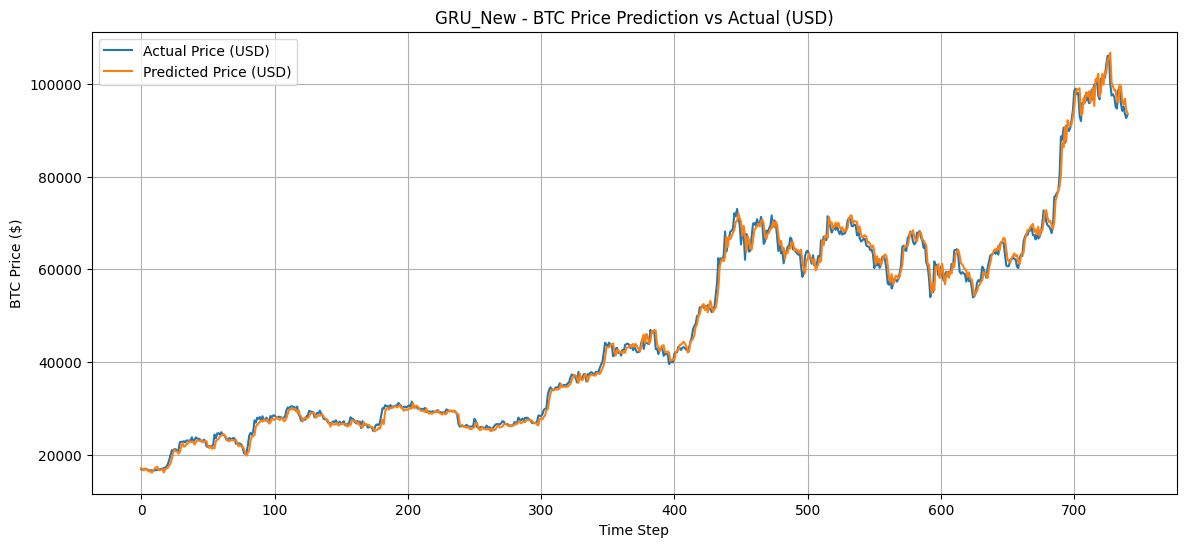

📈 GRU_New Evaluation in USD:
MAE: $1041.50
RMSE: $1507.08
R² Score: 0.9952
Pearson Correlation: 0.9977


In [9]:
plot_and_evaluate_usd(
    y_test, preds_gru,
    btc_full, feature_cols,
    MinMaxScaler(), model_name='GRU_New'
)

In [10]:
def backtest_model(model_fn, btc_scaled_df, target_column='close', window_size=700, forecast_horizon=30, step=30):
    all_preds = []
    all_true = []
    all_dates = []

    feature_cols = btc_scaled_df.columns.tolist()
    feature_cols.remove(target_column)

    for start in range(0, len(btc_scaled_df) - window_size - forecast_horizon + 1, step):
        end = start + window_size
        future_end = end + forecast_horizon

        X_train_window = []
        y_train_window = []

        for i in range(start, end - 60):
            X_train_window.append(btc_scaled_df.iloc[i:i+60][feature_cols].values)
            y_train_window.append(btc_scaled_df.iloc[i+60][target_column])

        X_train_window = np.array(X_train_window)
        y_train_window = np.array(y_train_window)

        model = model_fn((X_train_window.shape[1], X_train_window.shape[2]))
        print(f"Backtesting window {start} → {future_end}")
        model.fit(X_train_window, y_train_window, epochs=5, verbose=0)

        preds = []
        for i in range(end, future_end):
            X_input = btc_scaled_df.iloc[i-60:i][feature_cols].values.reshape(1, 60, len(feature_cols))
            pred = model.predict(X_input, verbose=0).flatten()[0]
            preds.append(pred)

        y_future = btc_scaled_df.iloc[end:future_end][target_column].values
        future_dates = btc_scaled_df.iloc[end:future_end].index

        all_preds.extend(preds)
        all_true.extend(y_future)
        all_dates.extend(future_dates)

    scaler = MinMaxScaler()
    scaler.fit(btc_scaled_df[[target_column]])
    all_preds_usd = scaler.inverse_transform(np.array(all_preds).reshape(-1, 1)).flatten()
    all_true_usd = scaler.inverse_transform(np.array(all_true).reshape(-1, 1)).flatten()

    return all_dates, all_true_usd, all_preds_usd


In [11]:
def evaluate_and_plot_backtest_results(all_preds_scaled, all_dates, btc_full_df, target_column='close'):
    all_true_usd = btc_full_df.loc[all_dates][target_column].values

    full_cols = btc_full_df.columns.tolist()
    dummy = np.zeros((len(all_preds_scaled), len(full_cols)))
    dummy[:, full_cols.index(target_column)] = all_preds_scaled

    scaler = MinMaxScaler()
    scaler.fit(btc_full_df[full_cols])

    all_preds_usd = scaler.inverse_transform(dummy)[:, full_cols.index(target_column)]

    mae = mean_absolute_error(all_true_usd, all_preds_usd)
    rmse = np.sqrt(mean_squared_error(all_true_usd, all_preds_usd))
    r2 = r2_score(all_true_usd, all_preds_usd)
    corr, _ = pearsonr(all_true_usd, all_preds_usd)

    print("📉 Backtesting Evaluation in USD:")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson Correlation: {corr:.4f}")

    plt.figure(figsize=(15, 6))
    plt.plot(all_dates, all_true_usd, label='True Price (USD)', color='blue')
    plt.plot(all_dates, all_preds_usd, label='Predicted Price (USD)', color='orange')
    plt.xlabel('Date')
    plt.ylabel('BTC Price (USD)')
    plt.title('Backtesting Results (GRU Predictions vs Actual)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
all_dates, all_true_usd, all_preds_usd = backtest_model(
    model_fn=build_residual_gru_light_dropout,
    btc_scaled_df=scaled,
    target_column='close',
    window_size=700,
    forecast_horizon=30,
    step=100
)

Backtesting window 0 → 730
Backtesting window 100 → 830
Backtesting window 200 → 930
Backtesting window 300 → 1030
Backtesting window 400 → 1130
Backtesting window 500 → 1230
Backtesting window 600 → 1330
Backtesting window 700 → 1430
Backtesting window 800 → 1530
Backtesting window 900 → 1630
Backtesting window 1000 → 1730
Backtesting window 1100 → 1830
Backtesting window 1200 → 1930
Backtesting window 1300 → 2030
Backtesting window 1400 → 2130
Backtesting window 1500 → 2230
Backtesting window 1600 → 2330
Backtesting window 1700 → 2430
Backtesting window 1800 → 2530
Backtesting window 1900 → 2630
Backtesting window 2000 → 2730
Backtesting window 2100 → 2830
Backtesting window 2200 → 2930
Backtesting window 2300 → 3030
Backtesting window 2400 → 3130
Backtesting window 2500 → 3230
Backtesting window 2600 → 3330
Backtesting window 2700 → 3430
Backtesting window 2800 → 3530
Backtesting window 2900 → 3630
Backtesting window 3000 → 3730


📉 Backtesting Evaluation in USD:
MAE: $1348.64
RMSE: $2133.52
R² Score: 0.9913
Pearson Correlation: 0.9966


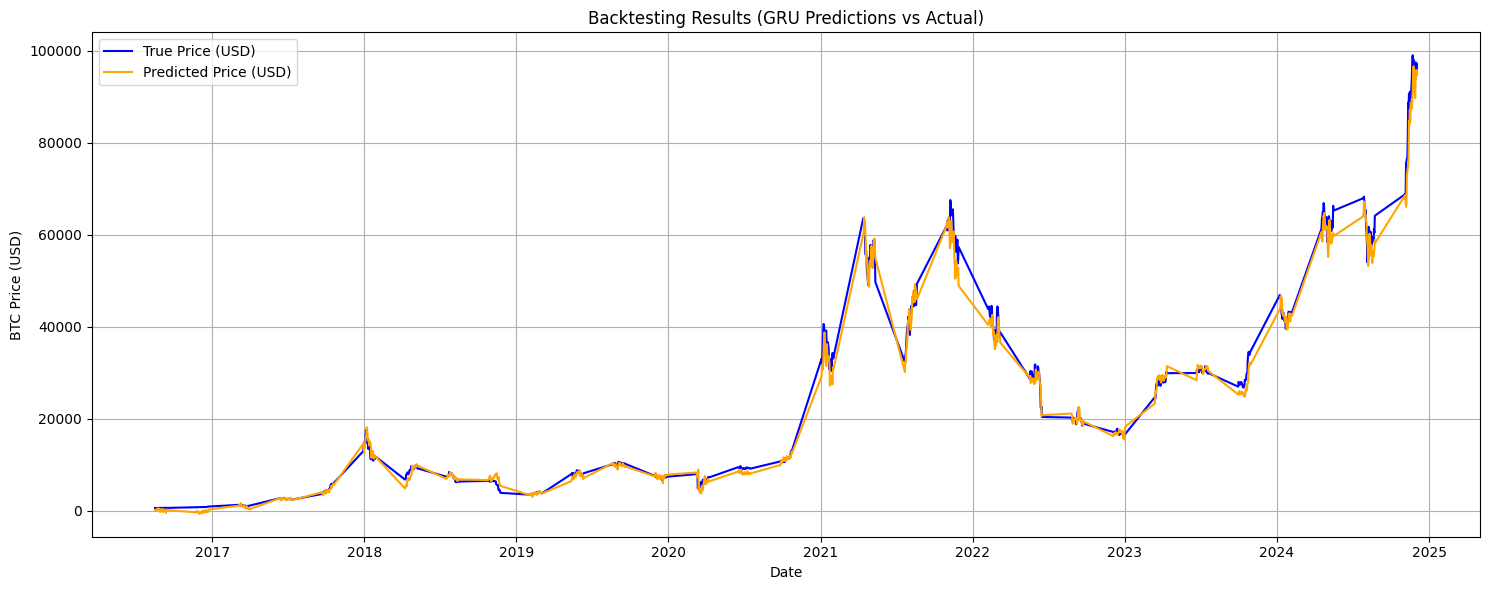

In [13]:
evaluate_and_plot_backtest_results(
    all_preds_scaled=all_preds_usd,
    all_dates=all_dates,
    btc_full_df=btc_full,
    target_column='close'
)
